In [1]:
import pandas as pd
import numpy as np

Split in categorical and numerical variables

In [2]:
df=pd.read_csv('datasets/train_table.csv',low_memory=False,index_col='ID')

y=df['attrition']
X=df.drop(columns='attrition')

# Create a DataFrame with numeric columns
X_numeric = X.select_dtypes(include=['number'])

# Create a DataFrame with object (categorical) columns
X_categorical = X.select_dtypes(include=['object'])


In [3]:
from sklearn.base import BaseEstimator,TransformerMixin
class SelectCatColumns (BaseEstimator,TransformerMixin):
    def __init__(self,list_columns):
        self.list_columns=list_columns
    def fit(self,X,y=None):
        return self
    def transform (self,X):
        return X[self.list_columns]

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_cols=X_numeric.columns.tolist()
cat_cols=X_categorical.columns.tolist()

In [5]:
flag_cat=X_categorical.describe().T
flag_cat['ratio']=flag_cat['freq']/flag_cat['count']
flag_cat['flag_delete']=np.where(flag_cat['ratio']>0.7,1,0)

In [6]:
col_st=flag_cat.loc[flag_cat['flag_delete']==0].index.to_list()

In [7]:
col_st

['product', 'entity', 'period', 'type_job', 'bureau_risk', 'product_1']

In [8]:
df_categorical=X_categorical[col_st]#.describe().T

In [9]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# pipecat=Pipeline([('feature',SelectCatColumns(col_st)),
#                   ('encoding',OneHotEncoder(handle_unknown='ignore',sparse=False,sparse_output=False).set_output(transform='pandas'))])

# Supongamos que tienes un DataFrame llamado 'data' con las columnas que deseas transformar

# Definir las columnas categóricas y numéricas
categorical_columns = ['product', 'entity', 'period', 'type_job', 'bureau_risk', 'product_1']
numeric_columns = num_cols  # Agrega tus columnas numéricas aquí

# Crear un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler().set_output(transform='pandas'), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse=False,sparse_output=False).set_output(transform='pandas'), categorical_columns),
    ],
    remainder='drop',
    n_jobs=-1
)

# Aplicar la transformación y configurar la salida en formato Pandas
preprocessor.set_output(transform='pandas')
X_tr = preprocessor.fit_transform(X)

# Ahora, data_transformed contendrá las columnas transformadas con one-hot encoding y StandardScaler en formato Pandas


In [10]:
from sklearn.decomposition import PCA

pca=PCA(random_state=23)
pca.fit(X_tr,y)

PCA(random_state=23)

23


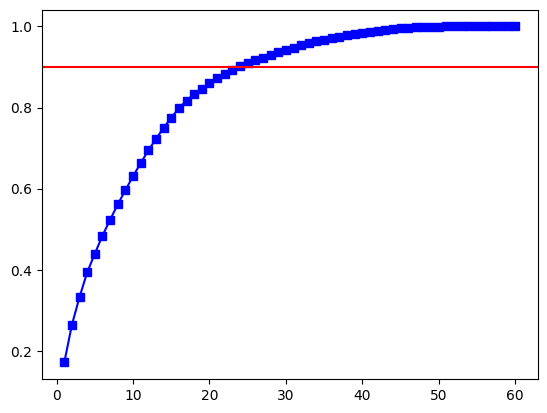

In [11]:
import matplotlib.pyplot as plt
cum_variance=np.cumsum(pca.explained_variance_ratio_)
x_axis=range(1,X_tr.shape[1]+1)
plt.plot(x_axis,cum_variance,'sb-')
#plt.xticks(range(0,X_tr.shape[0]),x_axis)
threshold=0.90
plt.axhline(y=threshold,color='r')
npca=len(cum_variance[cum_variance<threshold])
print(npca)


In [12]:
y.value_counts()/len(y)

attrition
0.0    0.870749
1.0    0.059311
5.0    0.028998
2.0    0.020272
4.0    0.011043
3.0    0.009627
Name: count, dtype: float64

In [13]:
from sklearn.model_selection import StratifiedKFold,cross_validate,RandomizedSearchCV
from sklearn.metrics import make_scorer,f1_score
from lightgbm import LGBMClassifier


skf=StratifiedKFold(n_splits=10,random_state=23,shuffle=True)
custom_f1score=make_scorer(f1_score,average='macro',zero_division=0)
pca=PCA(n_components=npca,random_state=23)
estimator=LGBMClassifier(random_state=23,n_jobs=2,class_weight='balanced')
model_pipe=Pipeline([('prep',preprocessor),
                     ('pca',pca),
                     ('clf',estimator)])

num_leaves=[10,31,40,50]
max_depth=[5,7,9,11,13,15,20]
n_estimators=[100,150,180,200,250,300]
learning_rate=[0.1,0.01]
boosting_type=['gbdt','dart','rf']

param_grid={'clf__num_leaves':num_leaves,
            'clf__max_depth':max_depth,
            'clf__n_estimators':n_estimators,
            'clf__learning_rate':learning_rate,
            'clf__boosting_type':boosting_type}

model_search=RandomizedSearchCV(estimator=model_pipe,
                                param_distributions=param_grid,
                                random_state=23,
                                n_iter=15,
                                scoring=custom_f1score,
                                cv=skf,
                                error_score=0,
                                return_train_score=True,
                                verbose=2,
                                n_jobs=2)

result_cv=cross_validate(X=X,
                         y=y,
                         estimator=model_search,
                         cv=skf,
                         scoring=custom_f1score,
                         return_train_score=True,
                         return_estimator=True,
                         n_jobs=4,
                         error_score=0)